In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import SelectKBest

In [10]:
import os
from pathlib import Path
#data_folder_path = os.path.join(os.path.dirname(__file__), '..', 'datasets')

cwd = Path(os.getcwd())

df_path = cwd.parent / 'datasets' / 'train.csv'

df = pd.read_csv(df_path)

In [11]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [13]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()


,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [14]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


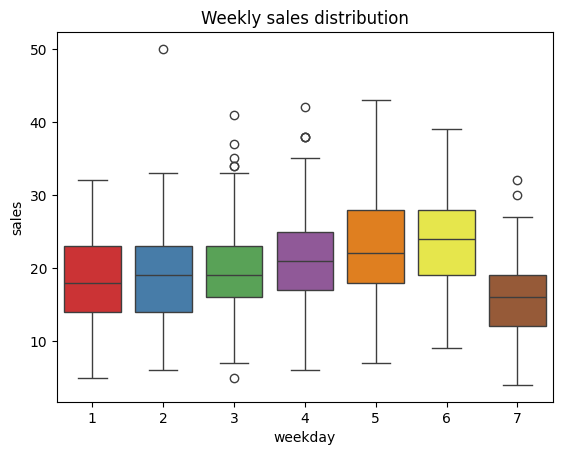

In [23]:
# WEEKLY
plot = sn.boxplot(x='weekday', y='sales', data=df,palette='Set1')
_ = plot.set(title='Weekly sales distribution')

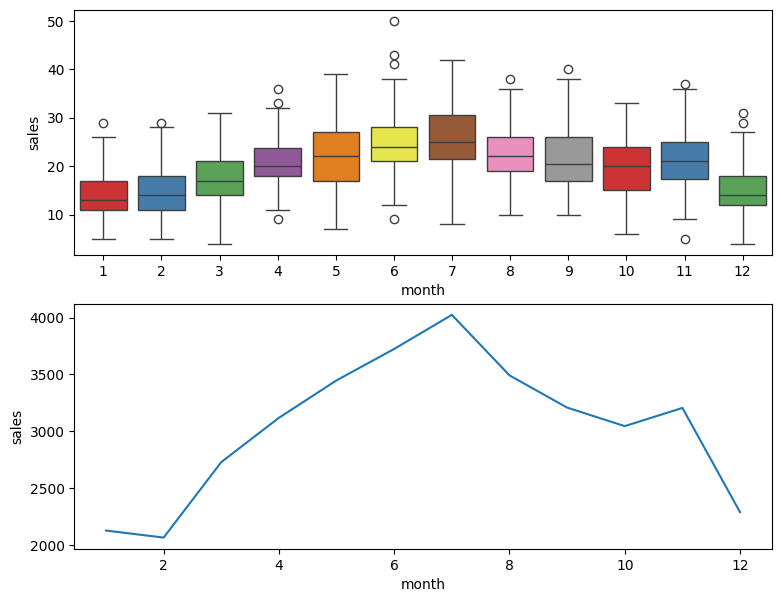

In [24]:
# MONTHLY 
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0], palette= 'Set1')
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

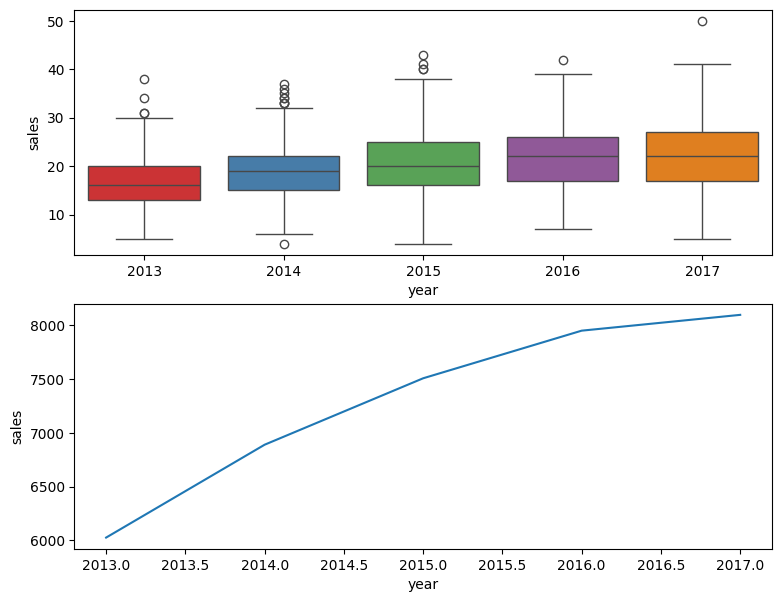

In [26]:
# YEARLY
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0],palette='Set1')
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

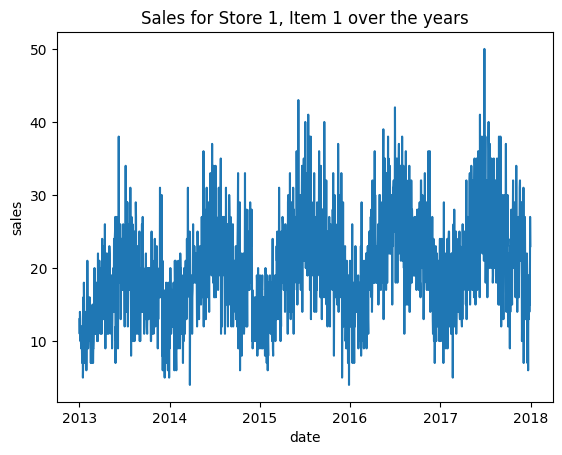

In [27]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

In [30]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12,use_boxcox=False)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()

print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


In [32]:
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

NameError: name 'errors_df' is not defined

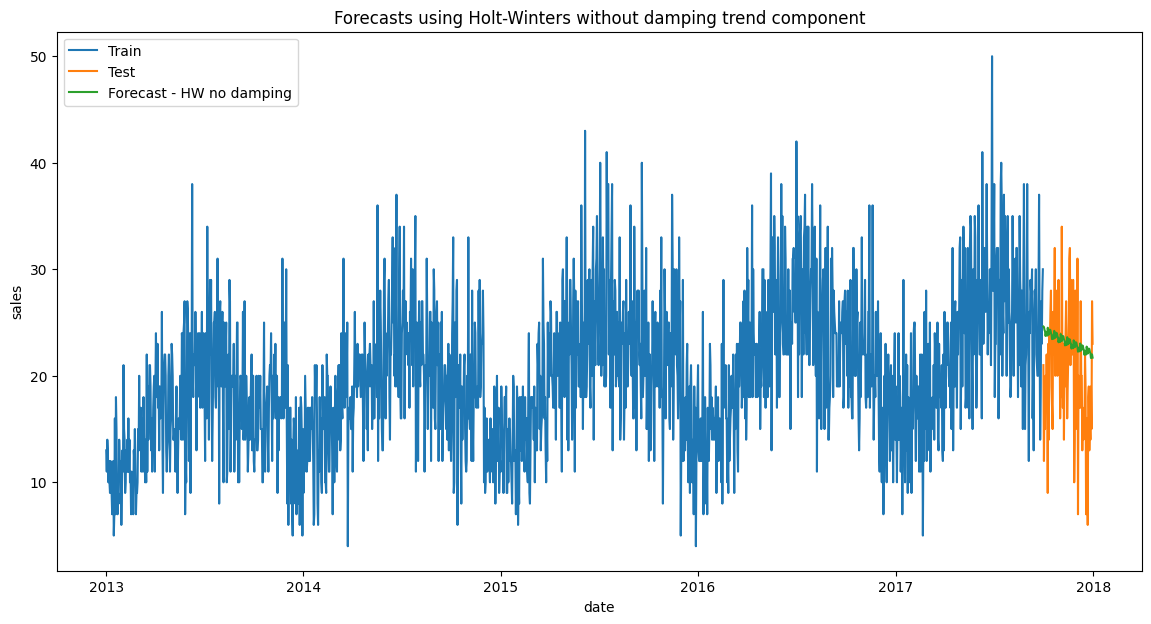

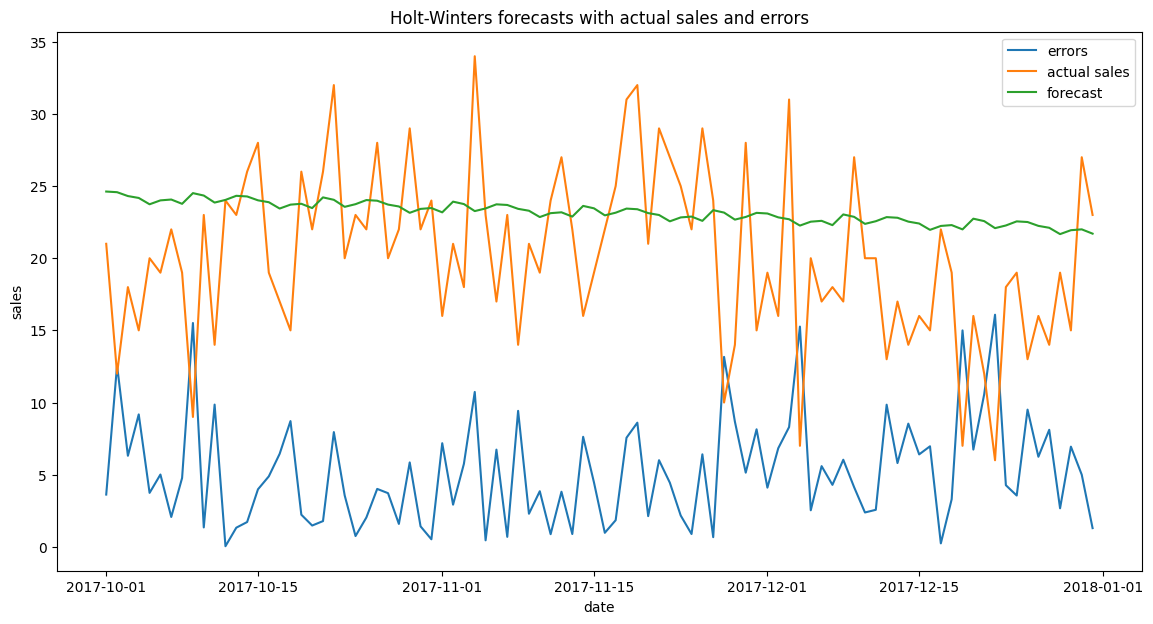

NameError: name 'mae' is not defined

In [31]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw